In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

<module 'gamma_SSN_losses' from '/home/cholt/Python/torch_SSN/jax_caleb/gamma_SSN_losses.py'>

In [4]:
os.getpid()

702

In [5]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [20]:
def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, f0, r_fp


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, obs_f0, r_fp = ssn_PS(params, contrasts) 
    
    if np.max(np.abs(np.imag(spect))) > 0.01:
        print("Spectrum is dangerously imaginary")
    
    #half_width_rates = 20 # basin around acceptable rates 
    lower_bound_rates = 0 # needs to be > 0, valley will start -lower_bound, 5 is a nice value with kink_control = 5
    upper_bound_rates = 80 # valley ends at upper_bound, keeps rates from blowing up
    kink_control = 1 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates
    
    prefact_rates = 1
    prefact_params = 10
    
    spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
    rates_loss = prefact_rates * losses.loss_rates_contrasts(r_fp, lower_bound_rates, upper_bound_rates, kink_control) #fourth arg is slope which is set to 1 normally
    param_loss = prefact_params * losses.loss_params(params)
#     peak_freq_loss = losses.loss_peak_freq(fs, obs_f0)
    
    if spect_loss/rates_loss < 1:
        print('rates loss is greater than spect loss')
#     print(spect_loss/rates_loss) 
    
    return spect_loss + param_loss + rates_loss # + peak_freq_loss #
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))




# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

run time: 1.166799783706665


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

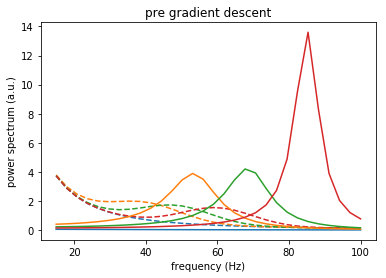

In [23]:
# params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
params_init = np.array([2.5/3, 1.3/3, 2.4/3, 1.0/3, 1.0, 1.0, 0.6/3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2, 1.0, 0.3]) # [Jee, Jei, Jie, Jii, gE, gI, nmdaRatio]
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, f0, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


rates loss is greater than spect loss
11.385462


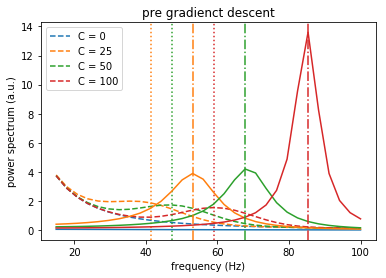

In [24]:
target_f0 = np.array(SSN_power_spec.find_peak_freq(fs, target_PS, len(test_contrasts)))
obs_f0 = np.array(SSN_power_spec.find_peak_freq(fs, spect, len(test_contrasts)))
color_order = ['tab:orange', 'tab:green', 'tab:red']
ind=0


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.legend(('C = 0', 'C = 25', 'C = 50', 'C = 100'))
for ff in target_f0:
    ax.axvline(x=ff, color=color_order[ind] , ls=':')
    ind += 1
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ind=0
for ff in obs_f0:
    ax.axvline(x=ff, color=color_order[ind] , ls='-.')
    ind += 1

ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

print(loss(params_init))

# Run Gradient Descent

In [ ]:
#dloss = grad(loss)
dloss = value_and_grad(loss)

gd_iters = 1000
eta = .001 #learning rate

params = params_init
loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1
rates loss is greater than spect loss


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss is greater than spect loss
rates loss i

/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

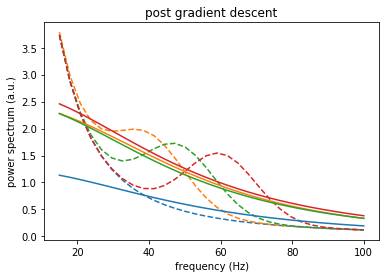

In [18]:
spect, fs, f0, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

Text(0.5,1,'I Rates')

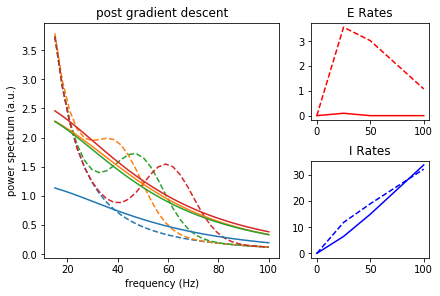

In [19]:
target_rates = losses.get_target_rates().T
obs_rates = r_fp.T

fig_combined = plt.figure(13, constrained_layout=True)
gs = gridspec.GridSpec(4,3, figure=fig_combined)

ax_spect = fig_combined.add_subplot(gs[:,0:2])
ax_spect.plot(fs, np.real(target_PS), "--")
#colrs = ax.get_color_cycle()
ax_spect.set_prop_cycle(None)
ax_spect.plot(fs, np.real(spect))
ax_spect.set_title('post gradient descent')
ax_spect.set_ylabel('power spectrum (a.u.)')
ax_spect.set_xlabel('frequency (Hz)')

ax_E = fig_combined.add_subplot(gs[0:2, 2])
ax_I = fig_combined.add_subplot(gs[2:, 2])

ax_E.plot(test_contrasts, target_rates[:, 0],  "r--")
ax_E.set_prop_cycle(None)
ax_E.plot(test_contrasts, obs_rates[:,0], 'r')
ax_E.set_title('E Rates')
# ax_E.set_xlabel('Contrasts')
# ax_E.set_ylabel('Firing Rates (Hz)')

ax_I.plot(test_contrasts, target_rates[:, 1],  "b--")
ax_I.set_prop_cycle(None)
ax_I.plot(test_contrasts, obs_rates[:,1], 'b')
ax_I.set_title('I Rates')
# ax_I.set_xlabel('Contrasts')
# ax_I.set_ylabel('Firing Rates (Hz)')

In [12]:
# half_width_rates = 20 # basin around acceptable rates 
lower_bound_rates = 5
upper_bound_rates = 80
kink_control = 5 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates
    
    
print(losses.loss_rates_contrasts(r_fp, lower_bound_rates, upper_bound_rates, kink_control))
print(losses.loss_spect_contrasts(fs, np.real(spect)))
print(params)
print(r_fp)

0.20959032
0.25939545
[2.5020356  1.2973093  2.3891156  1.0209554  0.85219616 1.1257368
 0.6558413 ]
[[0.0000000e+00 9.6267521e-02 6.3431899e-06 1.8641804e-05]
 [0.0000000e+00 6.4476395e+00 1.4898932e+01 3.3660896e+01]]


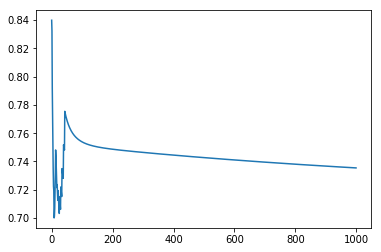

In [13]:
plt.plot(loss_t)

In [54]:
ideal_params = np.array([1.7, 1.525, 1.7, 0.5, 0.6])

print('Init Parameters ', params_init)
print('Found Parameters ', params)

print('Ground Truth Parameters ', ideal_params)

Init Parameters  [2.5 1.3 2.4 1.  1.  1.  0.6]
Found Parameters  [2.215861   1.1886845  2.4419672  1.1484814  0.63289255 0.7147526
 0.28001007]
Ground Truth Parameters  [1.7   1.525 1.7   0.5   0.6  ]


## If first loss didn't quite converge, run it again!

In [46]:
#dloss = grad(loss)
# dloss = value_and_grad(loss)

gd_iters = 1000
eta = eta #.005 #learning rate

# params = params_init
# loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  101
G.D. step  201
G.D. step  301
G.D. step  401
G.D. step  501
G.D. step  601
G.D. step  701
G.D. step  801
G.D. step  901
1000 GD steps took 4837.4157383441925 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [2.4374564 1.222656  2.4180098 1.1174014 0.9356065 1.0382547 1.0001299]


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'G.D. Step')

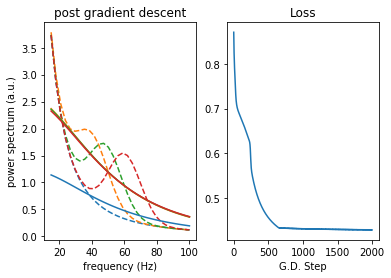

In [47]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, [ax, ax2] = plt.subplots(1,2)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

ax2.plot(loss_t[:])
ax2.set_title('Loss')
ax2.set_xlabel('G.D. Step')

## Save data 

In [22]:
import scipy.io as sio

data = {
    'params_final':params,
    'params_init':params_init,
    'spect_final':spect,
    'rfp_final':r_fp,
    'loss_t':loss_t,
    'ideal_fname':'standJ19-09-20-BestSpect.mat'
}


sio.savemat("IdealSpectra                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             _2019-10-15.mat", data)